In [2]:
import pandas as pd

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Użytkownik przesłał plik "{name}" o rozmiarze {length} bajtów'.format(
      name=fn, length=len(uploaded[fn])))


Saving matches-prepared.csv to matches-prepared.csv
Użytkownik przesłał plik "matches-prepared.csv" o rozmiarze 36695464 bajtów


In [4]:
df = pd.read_csv('matches-prepared.csv')

In [5]:
display(df.head())

,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,...,OddAway,C_LTH,C_LTA,C_VHD,C_VAD,C_HTB,C_PHB,match_result,total_goals,over25_binary
0,F1,2000-07-28,Marseille,Troyes,1686.34,1586.57,0.0,0.0,0.0,0.0,...,4.3,NaN,NaN,NaN,NaN,NaN,NaN,Win,4.0,1
1,F1,2000-07-28,Paris SG,Strasbourg,1714.89,1642.51,0.0,0.0,0.0,0.0,...,4.6,NaN,NaN,NaN,NaN,NaN,NaN,Win,4.0,1
2,F2,2000-07-28,Wasquehal,Nancy,1465.08,1633.80,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loss,1.0,0
3,F1,2000-07-29,Auxerre,Sedan,1635.58,1624.22,0.0,0.0,0.0,0.0,...,3.9,NaN,NaN,NaN,NaN,NaN,NaN,Loss,1.0,0
4,F1,2000-07-29,Bordeaux,Metz,1734.34,1673.11,0.0,0.0,0.0,0.0,...,4.3,NaN,NaN,NaN,NaN,NaN,NaN,Draw,2.0,0


### 1. Tworzenie zmiennej docelowej `high_score`

In [6]:
# Obliczanie sumy bramek
df['TotalGoals'] = df['FTHome'] + df['FTAway']

# Tworzenie zmiennej docelowej high_score
# 'yes' jeśli suma bramek > 2, 'no' w przeciwnym razie
df['high_score'] = df['TotalGoals'].apply(lambda x: 'yes' if x > 2 else 'no')

# Sprawdzenie rozkładu nowej zmiennej docelowej
print(df['high_score'].value_counts())
print("\n")

display(df[['FTHome', 'FTAway', 'TotalGoals', 'high_score']].head())

high_score
no     117279
yes    113275
Name: count, dtype: int64




,FTHome,FTAway,TotalGoals,high_score
0,3.0,1.0,4.0,yes
1,3.0,1.0,4.0,yes
2,0.0,1.0,1.0,no
3,0.0,1.0,1.0,no
4,1.0,1.0,2.0,no


### 2. Wybór cech i przygotowanie do kodowania/skalowania

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Zdefiniowanie cech (X) i zmiennej docelowej (y)
# Wyłączyłem kolumny, które nie są cechami lub są zmiennymi do stworzenia targetu, w tym te powodujące możliwy wyciek danych
X = df.drop(columns=['Division', 'MatchDate', 'FTHome', 'FTAway', 'TotalGoals', 'high_score', 'total_goals', 'over25_binary'])
y = df['high_score']

# Automatyczne wykrywanie cech numerycznych i kategorycznych
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Cechy numeryczne: {list(numerical_features)}")
print(f"Cechy kategoryczne: {list(categorical_features)}")

Cechy numeryczne: ['HomeElo', 'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'HTHome', 'HTAway', 'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget', 'HomeFouls', 'AwayFouls', 'HomeCorners', 'AwayCorners', 'HomeYellow', 'AwayYellow', 'HomeRed', 'AwayRed', 'OddHome', 'OddDraw', 'OddAway', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']
Cechy kategoryczne: ['HomeTeam', 'AwayTeam', 'FTResult', 'HTResult', 'match_result']


### 3. Dodatkowe przetwarzanie: kodowanie i skalowanie

In [8]:
from sklearn.impute import SimpleImputer

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Tworzenie preprocesora za pomocą ColumnTransformer
# Stosuję StandardScaler do cech numerycznych i OneHotEncoder do cech kategorycznych
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Zastosowanie preprocesora do danych
X_processed = preprocessor.fit_transform(X)

print(f"Kształt przetworzonego zbioru cech: {X_processed.shape}")

# Podział danych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kształt zbioru treningowego (X_train): {X_train.shape}")
print(f"Kształt zbioru testowego (X_test): {X_test.shape}")
print(f"Kształt zbioru treningowego (y_train): {y_train.shape}")
print(f"Kształt zbioru testowego (y_test): {y_test.shape}")

Kształt przetworzonego zbioru cech: (230554, 2458)
Kształt zbioru treningowego (X_train): (184443, 2458)
Kształt zbioru testowego (X_test): (46111, 2458)
Kształt zbioru treningowego (y_train): (184443,)
Kształt zbioru testowego (y_test): (46111,)


## Wytrenowanie modelu regresji logistycznej



In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("Zaimportowano moduły `LogisticRegression` i `accuracy_score`.")

Zaimportowano moduły `LogisticRegression` i `accuracy_score`.


In [10]:
model_lr = LogisticRegression(solver='liblinear', random_state=42)

# Trenowanie modelu
model_lr.fit(X_train, y_train)

# Predykcja na danych testowych
y_pred_lr = model_lr.predict(X_test)

# Obliczanie dokładności
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Dokładność modelu regresji logistycznej: {accuracy_lr:.4f}")

Dokładność modelu regresji logistycznej: 0.7437


## Wytrenowanie modelu maszyny wektorów nośnych (SVM)



In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

print("Zaimportowano moduły `LinearSVC` i `accuracy_score`.")

Zaimportowano moduły `LinearSVC` i `accuracy_score`.


In [12]:
model_svm = LinearSVC(random_state=42, dual=False)

# Trenowanie modelu
model_svm.fit(X_train, y_train)

# Predykcja na danych testowych
y_pred_svm = model_svm.predict(X_test)

# Obliczanie dokładności
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Dokładność modelu maszyny wektorów nośnych (LinearSVC): {accuracy_svm:.4f}")

Dokładność modelu maszyny wektorów nośnych (LinearSVC): 0.7431


## Wytrenowanie modelu lasu losowego (Random Forest)



In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("Zaimportowano moduły `RandomForestClassifier` i `accuracy_score`.")

Zaimportowano moduły `RandomForestClassifier` i `accuracy_score`.


In [14]:
model_rf = RandomForestClassifier(random_state=42)

# Trenowanie modelu
model_rf.fit(X_train, y_train)

# Predykcja na danych testowych
y_pred_rf = model_rf.predict(X_test)

# Obliczanie dokładności
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Dokładność modelu lasu losowego: {accuracy_rf:.4f}")

Dokładność modelu lasu losowego: 0.7577


In [15]:
print(f"Dokładność modelu regresji logistycznej: {accuracy_lr:.4f}")
print(f"Dokładność modelu maszyny wektorów nośnych (LinearSVC): {accuracy_svm:.4f}")
print(f"Dokładność modelu lasu losowego: {accuracy_rf:.4f}")

# Porównanie modeli
model_accuracies = {
    "Logistic Regression": accuracy_lr,
    "LinearSVC": accuracy_svm,
    "Random Forest": accuracy_rf
}

best_model = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model]

print(f"\nNajlepszym modelem pod względem dokładności jest: {best_model} z dokładnością: {best_accuracy:.4f}")

Dokładność modelu regresji logistycznej: 0.7437
Dokładność modelu maszyny wektorów nośnych (LinearSVC): 0.7431
Dokładność modelu lasu losowego: 0.7577

Najlepszym modelem pod względem dokładności jest: Random Forest z dokładnością: 0.7577


## Zapis wytrenowanego modelu


In [16]:
import joblib

# Utworzenie słownika zawierającego wszystkie wytrenowane modele
all_models = {
    'Logistic Regression': model_lr,
    'LinearSVC': model_svm,
    'Random Forest': model_rf
}

# Zapisanie wszystkich modeli do pliku
filename = 'high_score_model.pkl'
joblib.dump(all_models, filename)

print(f"Wszystkie wytrenowane modele zostały pomyślnie zapisane do '{filename}'")

Wszystkie wytrenowane modele zostały pomyślnie zapisane do 'high_score_model.pkl'


### Testowanie zapisanego modelu


In [17]:
# Wczytanie wszystkich modeli z pliku
all_models_loaded = joblib.load(filename)
print(f"Wszystkie modele zostały pomyślnie wczytane z '{filename}'")

# Wybór konkretnego modelu do testowania (np. Random Forest)
loaded_model = all_models_loaded['Random Forest']

# Wykonanie predykcji na wczytanym modelu (przykładowo na fragmencie danych testowych)
y_pred_loaded = loaded_model.predict(X_test)

# Sprawdzenie, czy predykcje wczytanego modelu są takie same jak oryginalne
from sklearn.metrics import accuracy_score
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)

print(f"Dokładność wczytanego modelu Random Forest na danych testowych: {accuracy_loaded:.4f}")

if accuracy_loaded == accuracy_rf:
    print("Wczytany model Random Forest działa poprawnie i daje identyczne wyniki jak oryginalny.")
else:
    print("Błąd. Dokładność wczytanego modelu Random Forest różni się od oryginalnego.")

Wszystkie modele zostały pomyślnie wczytane z 'high_score_model.pkl'
Dokładność wczytanego modelu Random Forest na danych testowych: 0.7577
Wczytany model Random Forest działa poprawnie i daje identyczne wyniki jak oryginalny.


### 4. Obliczanie metryk ewaluacyjnych i wizualizacja macierzy pomyłek dla każdego modelu


Wyniki dla modelu: Logistic Regression
Accuracy: 0.7437
Precision: 0.7316
Recall: 0.7556
F1-Score: 0.7434

Classification Report:
              precision    recall  f1-score   support

          no       0.76      0.73      0.74     23456
         yes       0.73      0.76      0.74     22655

    accuracy                           0.74     46111
   macro avg       0.74      0.74      0.74     46111
weighted avg       0.74      0.74      0.74     46111



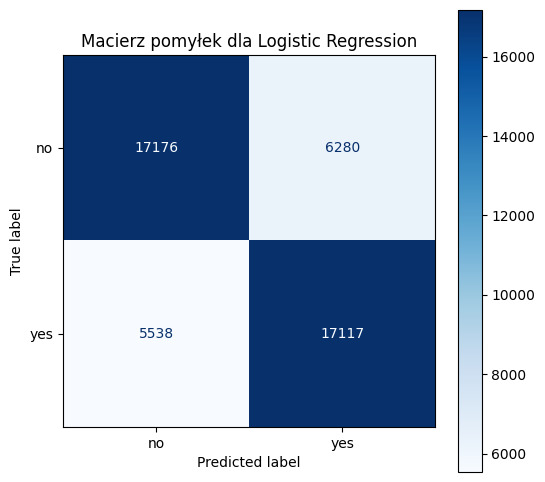


Wyniki dla modelu: LinearSVC
Accuracy: 0.7431
Precision: 0.7354
Recall: 0.7450
F1-Score: 0.7402

Classification Report:
              precision    recall  f1-score   support

          no       0.75      0.74      0.75     23456
         yes       0.74      0.75      0.74     22655

    accuracy                           0.74     46111
   macro avg       0.74      0.74      0.74     46111
weighted avg       0.74      0.74      0.74     46111



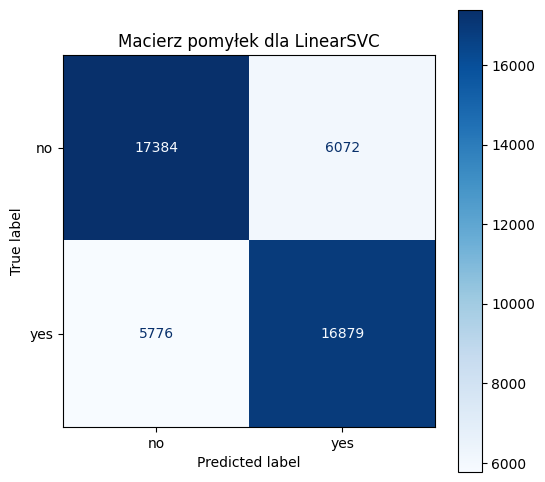


Wyniki dla modelu: Random Forest
Accuracy: 0.7577
Precision: 0.7675
Recall: 0.7272
F1-Score: 0.7468

Classification Report:
              precision    recall  f1-score   support

          no       0.75      0.79      0.77     23456
         yes       0.77      0.73      0.75     22655

    accuracy                           0.76     46111
   macro avg       0.76      0.76      0.76     46111
weighted avg       0.76      0.76      0.76     46111



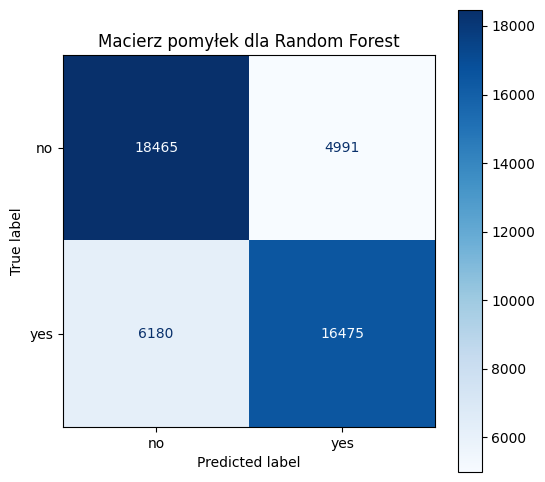

In [21]:
# Importowanie potrzebnych bibliotek do metryk i wizualizacji
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, y_pred, model_name):
    # Obliczanie metryk ewaluacyjnych
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='yes')
    recall = recall_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')

    print(f"\nWyniki dla modelu: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Wizualizacja macierzy pomyłek
    cm = confusion_matrix(y_test, y_pred, labels=['no', 'yes'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(f'Macierz pomyłek dla {model_name}')
    plt.show()

    return accuracy, precision, recall, f1

# Słownik do przechowywania wszystkich metryk
all_metrics = {}

# Ewaluacja modelu regresji logistycznej
accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(model_lr, X_test, y_test, y_pred_lr, "Logistic Regression")
all_metrics['Logistic Regression'] = {'Accuracy': accuracy_lr, 'Precision': precision_lr, 'Recall': recall_lr, 'F1-Score': f1_lr}

# Ewaluacja modelu maszyny wektorów nośnych (LinearSVC)
accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(model_svm, X_test, y_test, y_pred_svm, "LinearSVC")
all_metrics['LinearSVC'] = {'Accuracy': accuracy_svm, 'Precision': precision_svm, 'Recall': recall_svm, 'F1-Score': f1_svm}

# Ewaluacja modelu lasu losowego (Random Forest)
accuracy_rf, precision_rf, recall_rf, f1_rf = evaluate_model(model_rf, X_test, y_test, y_pred_rf, "Random Forest")
all_metrics['Random Forest'] = {'Accuracy': accuracy_rf, 'Precision': precision_rf, 'Recall': recall_rf, 'F1-Score': f1_rf}

### 5. Porównanie wyników wszystkich modeli


Porównanie metryk ewaluacyjnych wszystkich modeli


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.743705,0.731590,0.755551,0.743377
LinearSVC,0.743055,0.735436,0.745045,0.740210
Random Forest,0.757737,0.767493,0.727213,0.746810


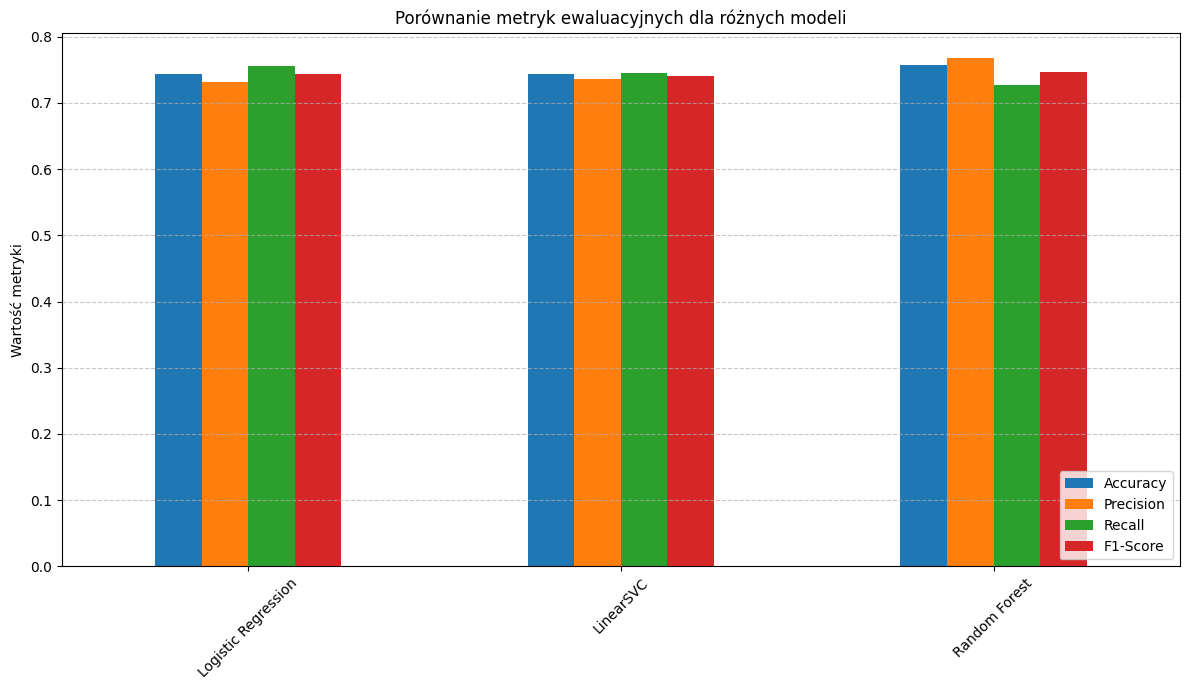

In [22]:

metrics_df = pd.DataFrame(all_metrics).T

print("\nPorównanie metryk ewaluacyjnych wszystkich modeli")
display(metrics_df)

# Wizualizacja porównania metryk
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.title('Porównanie metryk ewaluacyjnych dla różnych modeli')
plt.ylabel('Wartość metryki')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()